In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/
/home/ikeuchi/Share/GLOFRIM/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)


/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/PCR


## create DFM model BMI object

In [6]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date)

/home/ikeuchi/Share/DFLOW-FM//dflowfm-1.1.267/lib/libdflowfm.so
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/delta/
/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/DFM


## intitialize DFM model first to expose 1d coords

In [7]:
# initialize DFM to expose model coordinates via BMI
DFM_bmi.initialize()

## set coupling between PCR and DFM

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

Text(0.5,1,u'PCR coupled to DFM mask')

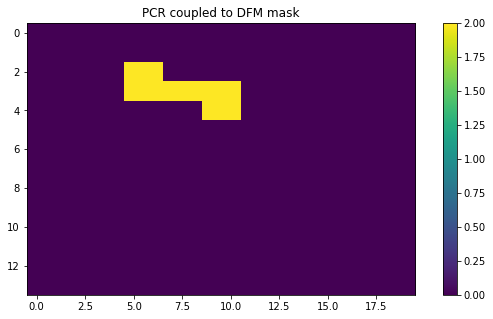

In [8]:
# get coupled dictionaries
PCR_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(PCR_bmi.coupled_mask, vmin=0, vmax=2, interpolation=None)
plt.colorbar()
b.set_title('PCR coupled to DFM mask')

/home/ikeuchi/.pyenv/versions/anaconda2-5.0.1/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,u'coupled matrix')

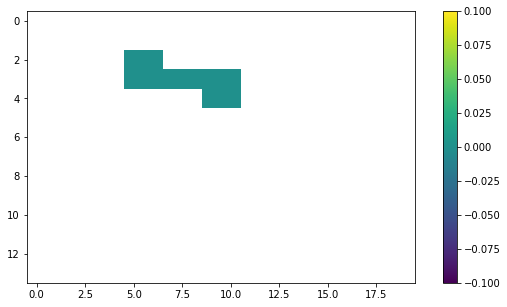

In [9]:
upMatrix = np.ma.masked_equal(PCR_bmi.upstream_matrix, -9999)

plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(upMatrix, interpolation=None)
plt.colorbar()
b.set_title('coupled matrix')

Text(0.5,1,u'coupled matrix')

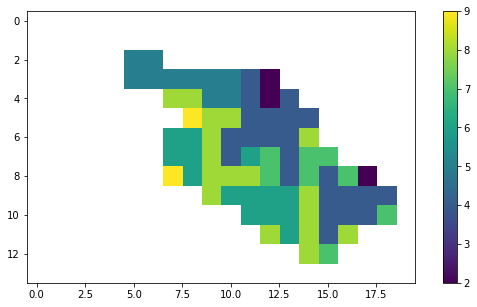

In [10]:
upMatrix = np.ma.masked_equal(PCR_bmi.ldd_modified, -9999)

plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(upMatrix, interpolation=None)
plt.colorbar()
b.set_title('coupled matrix')

In [11]:
# initialize PCR to after editing ldd grid
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-04-17 16:37:00.731204
2018-04-17 16:37:01,038 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-04-17 16:37:00.731204
INFO: configuration.initialize_logging(): Logging output to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-04-17T16:37:00.731204.log
2018-04-17 16:37:01,042 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30min/PCR2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-04-17T16:37:00.731204.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-04-17 16:37:01,062 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used

## run coupled PCR - DFM model

In [12]:
# run coupled model for 2 timesteps
def get_PCR_delta_vol():
    # coupled 2d mask
    mask = PCR_bmi.coupled_mask > 0
    # Q outflow 2D for coupled cells
    # NOTE: see if we can change this for cell inflow, like with the get_CMF_delta_vol
    q_out = np.where(mask, PCR_bmi.get_var('discharge'), 0) # [m3/s]
    q_out = q_out * 86400.
    # PCR runoff inflow 2D for coupled cells
    runoff = np.where(mask, PCR_bmi.get_var('runoff') * PCR_bmi.get_var('cellArea'), 0) # [m3/day]
    # take discharge in most upstream coupled cells, runoff for other cells
    #tot_flux = np.where(PCR_bmi.coupled_mask == 2, q_out, q_out)
    tot_flux = np.where(PCR_bmi.coupled_mask == 2, q_out, runoff)
    #tot_flux = np.where(PCR_bmi.coupled_mask == 2, runoff, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux * PCR_bmi.options['dt'] # [m3/day]
    return delta_vol 


DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
PCRidx = PCR_bmi.coupled_idx
PCRfrac = PCR_bmi.coupled_area_frac

def set_DFM_forcing():
    PCR_delta_vol = get_PCR_delta_vol() # 2d array [m3/day]
    print np.sum(PCR_delta_vol)
    DFM_depth_conservative = PCR_delta_vol[PCRidx] * PCRfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    zerorain = np.zeros_like(np.copy(DFM_bmi.get_var('rain')))
    DFM_bmi.set_var('rain', zerorain)
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
    return PCR_delta_vol

Text(0.5,1,u'coupled matrix')

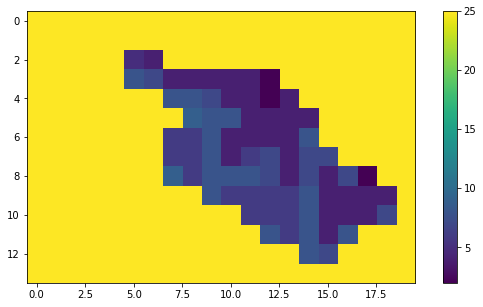

In [13]:
pcrLDD = np.copy(PCR_bmi.get_var(('routing', 'lddMap'))) 

plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(pcrLDD, interpolation=None)
plt.colorbar()
b.set_title('coupled matrix')

In [14]:
tStart = datetime.now()
# for i in range(timeSteps):
for i in range(80):
    PCR_bmi.update()
    set_DFM_forcing()
    DFM_bmi.update()  

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-04-17 16:37:13,383 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-04-17 16:37:13,608 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-04-17 16:37:15,491 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1


6.81998e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-04-17 16:37:26,127 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-04-17 16:37:26,134 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO: pcrglobwb.update(): updating model to time 2000-01-02
2018-04-17 16:37:26,377 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2
2018-04-17 16:37:27,349 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-02, timestep 2


9.8872e+08


INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.0
2018-04-17 16:37:41,742 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 172800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-03
2018-04-17 16:37:41,747 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-03
INFO: pcrglobwb.update(): updating model to time 2000-01-03
2018-04-17 16:37:41,974 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3
2018-04-17 16:37:42,930 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-03, timestep 3


1.24676e+09


KeyboardInterrupt: 

Text(0.5,1,u'coupled matrix')

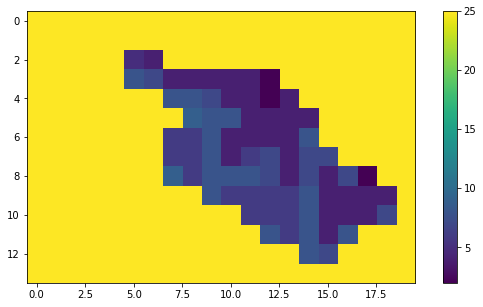

In [15]:
pcrLDD = np.copy(PCR_bmi.get_var(('routing', 'lddMap'))) 

plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(pcrLDD, interpolation=None)
plt.colorbar()
b.set_title('coupled matrix')

In [ ]:
tEnd = datetime.now()

In [ ]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd

In [ ]:
DFM_bmi.finalize()
PCR_bmi.finalize()

In [ ]:
#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
no = Dataset(fo, 'r')
#- extract simulated discharge from nc-file (for this run)
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
no_stA = Dataset(fo_stA, 'r')
#- extract simulated discharge from nc-file for DFM standalone
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_stA))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    
#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)

#- plot
plt.figure(figsize=(16,8))
plt.plot(qsim_ND, 'b', label = 'PCR->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4300, 'PCR->DFM : '+str(KGE_ND))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2DFM.png'), dpi=300)